# 01_EDA_and_Cleaning

## Contents

1. Libraries Used
2. Importing Data
3. Data Cleaning
4. EDA 

### Importing Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

%matplotlib inline

### Importing Data

In [6]:
df = pd.read_csv('./datasets/train.csv')

In [7]:
df.head()

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   
2  153  535304180           20        RL          68.0      7922   Pave   NaN   
3  318  916386060           60        RL          73.0      9802   Pave   NaN   
4  255  906425045           50        RL          82.0     14235   Pave   NaN   

  Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC Fence  \
0       IR1          Lvl  ...            0         0     NaN   NaN   
1       IR1          Lvl  ...            0         0     NaN   NaN   
2       Reg          Lvl  ...            0         0     NaN   NaN   
3       Reg          Lvl  ...            0         0     NaN   NaN   
4       IR1          Lvl  ...            0         0     NaN   NaN   

  Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
0          NaN        0       3    2010        WD      130500  
1          NaN        0       4    2009        WD      220000  
2          NaN        0       1    2010        WD      109000  
3          NaN        0       4    2010        WD      174000  
4          NaN        0       3    2010        WD      138500  

[5 rows x 81 columns]

## Data Cleaning

In [8]:
# Check size of df_train

df.shape

(2051, 81)

In [9]:
# Check for NAs
def check_na(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
    return missing_data.head(20)

check_na(df)

Total   Percent
Pool QC          2042  0.995612
Misc Feature     1986  0.968308
Alley            1911  0.931741
Fence            1651  0.804973
Fireplace Qu     1000  0.487567
Lot Frontage      330  0.160897
Garage Finish     114  0.055583
Garage Cond       114  0.055583
Garage Qual       114  0.055583
Garage Yr Blt     114  0.055583
Garage Type       113  0.055095
Bsmt Exposure      58  0.028279
BsmtFin Type 2     56  0.027304
BsmtFin Type 1     55  0.026816
Bsmt Cond          55  0.026816
Bsmt Qual          55  0.026816
Mas Vnr Type       22  0.010726
Mas Vnr Area       22  0.010726
Bsmt Half Bath      2  0.000975
Bsmt Full Bath      2  0.000975

In [16]:
# Check datatypes

df.dtypes.value_counts()

object     42
int64      28
float64    11
dtype: int64

We can split the dataset into two parts - ideally one for strings/categorical data and numeric data. But first, we have to ensure from the data dictionary that the datatype is being typecasted properly.

### Type Checking (Nominal Features)

In [17]:
nominal_features = ['MS SubClass','MS Zoning','Street',
                   'Alley','Lot Shape','Land Contour',
                   'Utilities','Lot Config','Land Slope',
                   'Neighborhood','Condition 1','Condition 2',
                   'Bldg Type','House Style','Overall Qual',
                   'Overall Cond',
                   'Roof Style','Roof Matl','Exterior 1st',
                   'Exterior 2nd', 'Mas Vnr Type','Exter Qual',
                   'Exter Cond','Foundation','Bsmt Qual','Bsmt Cond',
                   'Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2',
                   'Heating','Heating QC','Central Air','Electrical',
                   'Bsmt Full Bath','Bsmt Half Bath','Full Bath',
                   'Half Bath','Bedroom AbvGr','Kitchen AbvGr','Kitchen Qual',
                   'TotRms AbvGrd','Functional','Fireplaces',
                   'Fireplace Qu','Garage Type',
                   'Garage Finish','Garage Cars','Garage Qual',
                   'Garage Cond','Paved Drive','Pool QC','Fence',
                   'Misc Feature','Mo Sold',
                   'Sale Type']

temporal_features = ['Year Built','Year Remod/Add','Garage Yr Blt','Yr Sold']

non_numeric_features  = nominal_features + temporal_features

# convert nominal features into category datatype
for f in nominal_features:
    df[f] = df[f].astype("category")

Do the same for numerical columns


### Type Checking (Numerical Features)

In [18]:
cont_columns = [col for col in df.columns if col not in non_numeric_features]

In [19]:
#remove PID, Id from cont_columns 
cont_columns = [col for col in cont_columns if col not in ['PID','Id']]

In [20]:
cont_columns

['Lot Frontage',
 'Lot Area',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'Garage Area',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Pool Area',
 'Misc Val',
 'SalePrice']

In [21]:
df[cont_columns].dtypes

Lot Frontage       float64
Lot Area             int64
Mas Vnr Area       float64
BsmtFin SF 1       float64
BsmtFin SF 2       float64
Bsmt Unf SF        float64
Total Bsmt SF      float64
1st Flr SF           int64
2nd Flr SF           int64
Low Qual Fin SF      int64
Gr Liv Area          int64
Garage Area        float64
Wood Deck SF         int64
Open Porch SF        int64
Enclosed Porch       int64
3Ssn Porch           int64
Screen Porch         int64
Pool Area            int64
Misc Val             int64
SalePrice            int64
dtype: object

Dropping ID and PID columns (no semantical linkage)

In [22]:
df.drop(['Id','PID'],axis=1,inplace=True)

## EDA on Nominal Features

In [240]:
def subplot_boxplot(dataframe, list_of_columns,reference='SalePrice'):
    nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=2,figsize = (15,100)) # You'll want to specify your figsize

    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        sns.boxplot(x=dataframe[column],y=dataframe[reference],ax=ax[i])

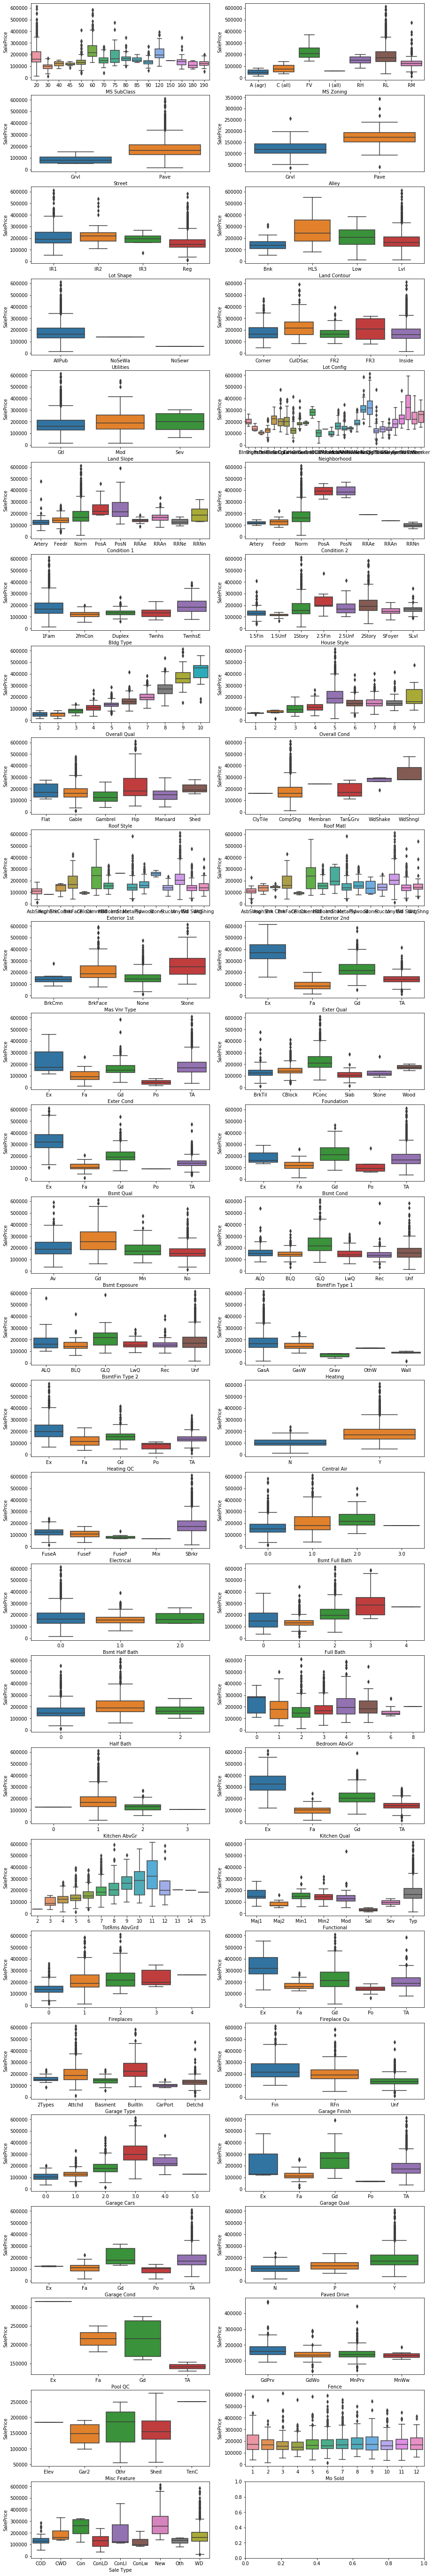

In [241]:
subplot_boxplot(df,nominal_features)

From the boxplots, we can see that the `year` features may prove tricky to handle and as such we need to transform the columns into a feature that would make sense as a regressor

### Handling features with `year` 

For a start, we can use binning to group the age of houses at the time of sale. Also, we will create a new feature `has_remod` to indicate if the house has undergone remodelling. Two features will be created. Namely, `age_since_built` and `age_since_remodel`.

For garage age, a feature `garage age` will be created.

In [242]:
df.filter(regex='Year|Yr').describe()

Year Built  Year Remod/Add  Garage Yr Blt      Yr Sold
count  2051.000000     2051.000000    1937.000000  2051.000000
mean   1971.708922     1984.190151    1978.707796  2007.775719
std      30.177889       21.036250      25.441094     1.312014
min    1872.000000     1950.000000    1895.000000  2006.000000
25%    1953.500000     1964.500000    1961.000000  2007.000000
50%    1974.000000     1993.000000    1980.000000  2008.000000
75%    2001.000000     2004.000000    2002.000000  2009.000000
max    2010.000000     2010.000000    2207.000000  2010.000000

In [243]:
df.filter(regex='Year|Yr|Garage').isna().sum()

Year Built          0
Year Remod/Add      0
Garage Type       113
Garage Yr Blt     114
Garage Finish     114
Garage Cars         1
Garage Area         1
Garage Qual       114
Garage Cond       114
Yr Sold             0
dtype: int64

We can observe that the missing years are due to lack of a garage in the first place. 

In [244]:
df['age_since_built'] = df['Yr Sold'] - df['Year Built']

In [245]:
df['age_since_remodel'] = df['Yr Sold'] - df['Year Remod/Add']

In [246]:
df['garage_age'] = df.apply(lambda x: (x['Yr Sold'] - x['Year Remod/Add']) if type(x['Garage Yr Blt']) == 'nan' else (x['Yr Sold'] - x['Garage Yr Blt']) , axis=1)

In [247]:
df.garage_age.sort_values(ascending=True).head()

1699   -200.0
1885     -1.0
1424      0.0
1758      0.0
867       0.0
Name: garage_age, dtype: float64

In [248]:
df.at[1699,'garage_age'] = 0
df.at[1885,'garage_age'] = 0

In [249]:
df['has_remod'] = df.apply(lambda x: 0 if x.age_since_built - x.age_since_remodel == 0 else 1, axis=1)

In [279]:
df['has_remod'].value_counts()

0    1101
1     950
Name: has_remod, dtype: int64

In [281]:
df['has_remod'] = df['has_remod'].astype('category')

In [251]:
nominal_features.append('has_remod')

From the following transformation, we can then drop the redundant columns of year built, year remod in place of binning

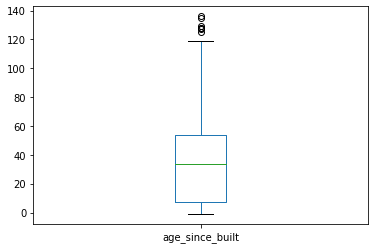

In [252]:
df['age_since_built'].plot.box()

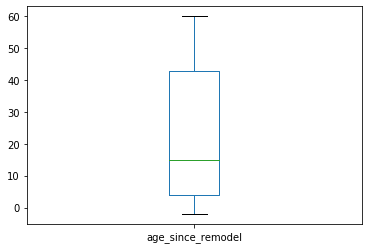

In [253]:
df['age_since_remodel'].plot.box()

In [254]:
#dropped original features used for transformation

df.drop(columns=['Year Built','Year Remod/Add','Garage Yr Blt'],inplace=True)

## Domain Information

> SPECIAL NOTES:
There are 5 observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will indicate them quickly). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these 5 unusual observations) before assigning it to students.

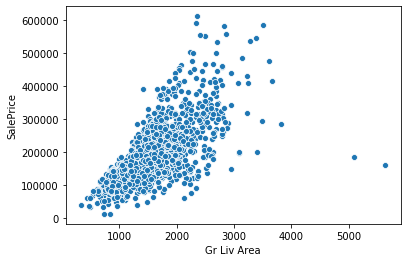

In [14]:
sns.scatterplot(x='Gr Liv Area',y='SalePrice',data=df)

In [29]:
# Removing houses with > 4000 sq ft
df = df[df['Gr Liv Area'] <= 4000]

### Check column variability

We want to check for low column variability, as low variability would make it less likely to affect the regression model. Dropping columns is costly, but we need to reduce model complexity.

In [3]:
df[nominal_features].var(axis=0,ddof=0).sort_values().head(10)

NameError: name 'df' is not defined

While we can probably drop columns due to low variability, we shall include all the features for the first model or use techniques such as lasso regression to drop it.

### Handling NA values for categorical variables

In [283]:
{key:list(feature.unique())  for key,feature in df[nominal_features].iteritems()}

{'MS SubClass': [60,
  20,
  50,
  180,
  160,
  70,
  120,
  190,
  85,
  30,
  90,
  80,
  75,
  45,
  40,
  150],
 'MS Zoning': ['RL', 'RM', 'FV', 'C (all)', 'A (agr)', 'RH', 'I (all)'],
 'Street': ['Pave', 'Grvl'],
 'Alley': [nan, 'Pave', 'Grvl'],
 'Lot Shape': ['IR1', 'Reg', 'IR2', 'IR3'],
 'Land Contour': ['Lvl', 'HLS', 'Bnk', 'Low'],
 'Utilities': ['AllPub', 'NoSeWa', 'NoSewr'],
 'Lot Config': ['CulDSac', 'Inside', 'Corner', 'FR2', 'FR3'],
 'Land Slope': ['Gtl', 'Sev', 'Mod'],
 'Neighborhood': ['Sawyer',
  'SawyerW',
  'NAmes',
  'Timber',
  'Edwards',
  'OldTown',
  'BrDale',
  'CollgCr',
  'Somerst',
  'Mitchel',
  'StoneBr',
  'NridgHt',
  'Gilbert',
  'Crawfor',
  'IDOTRR',
  'NWAmes',
  'Veenker',
  'MeadowV',
  'SWISU',
  'NoRidge',
  'ClearCr',
  'Blmngtn',
  'BrkSide',
  'NPkVill',
  'Blueste',
  'GrnHill',
  'Greens',
  'Landmrk'],
 'Condition 1': ['RRAe',
  'Norm',
  'PosA',
  'Artery',
  'Feedr',
  'PosN',
  'RRAn',
  'RRNe',
  'RRNn'],
 'Condition 2': ['Norm',
  'RRN

In [290]:
numerical_categories = ["MS SubClass","Overall Qual","Overall Cond","Bsmt Full Bath","Bsmt Half Bath","Full Bath","Half Bath","Bedroom AbvGr","Kitchen AbvGr","Garage Cars"]

word_categories = [col for col in nominal_features if col not in numerical_categories]


In [293]:
word_categories

['MS Zoning',
 'Street',
 'Alley',
 'Lot Shape',
 'Land Contour',
 'Utilities',
 'Lot Config',
 'Land Slope',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Exter Qual',
 'Exter Cond',
 'Foundation',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin Type 2',
 'Heating',
 'Heating QC',
 'Central Air',
 'Electrical',
 'Kitchen Qual',
 'TotRms AbvGrd',
 'Functional',
 'Fireplaces',
 'Fireplace Qu',
 'Garage Type',
 'Garage Finish',
 'Garage Qual',
 'Garage Cond',
 'Paved Drive',
 'Pool QC',
 'Fence',
 'Misc Feature',
 'Mo Sold',
 'Sale Type',
 'has_remod',
 'Yr Sold']

In [292]:
{key:list(feature.unique())  for key,feature in df[word_categories].iteritems()}

{'MS Zoning': ['RL', 'RM', 'FV', 'C (all)', 'A (agr)', 'RH', 'I (all)'],
 'Street': ['Pave', 'Grvl'],
 'Alley': [nan, 'Pave', 'Grvl'],
 'Lot Shape': ['IR1', 'Reg', 'IR2', 'IR3'],
 'Land Contour': ['Lvl', 'HLS', 'Bnk', 'Low'],
 'Utilities': ['AllPub', 'NoSeWa', 'NoSewr'],
 'Lot Config': ['CulDSac', 'Inside', 'Corner', 'FR2', 'FR3'],
 'Land Slope': ['Gtl', 'Sev', 'Mod'],
 'Neighborhood': ['Sawyer',
  'SawyerW',
  'NAmes',
  'Timber',
  'Edwards',
  'OldTown',
  'BrDale',
  'CollgCr',
  'Somerst',
  'Mitchel',
  'StoneBr',
  'NridgHt',
  'Gilbert',
  'Crawfor',
  'IDOTRR',
  'NWAmes',
  'Veenker',
  'MeadowV',
  'SWISU',
  'NoRidge',
  'ClearCr',
  'Blmngtn',
  'BrkSide',
  'NPkVill',
  'Blueste',
  'GrnHill',
  'Greens',
  'Landmrk'],
 'Condition 1': ['RRAe',
  'Norm',
  'PosA',
  'Artery',
  'Feedr',
  'PosN',
  'RRAn',
  'RRNe',
  'RRNn'],
 'Condition 2': ['Norm',
  'RRNn',
  'Feedr',
  'Artery',
  'PosA',
  'PosN',
  'RRAe',
  'RRAn'],
 'Bldg Type': ['1Fam', 'TwnhsE', 'Twnhs', '2fmCon

#### Treat missing numerical nominal features as 0

In [295]:
df[numerical_categories]=df[numerical_categories].replace(np.nan,0)

#### Treat missing categorical nominal features as missing

In [296]:
df[word_categories]=df[word_categories].replace(np.nan,'missing')

In [297]:
## Get unique items in each column

{key:list(feature.unique())  for key,feature in df[nominal_features].iteritems()}

{'MS SubClass': [60,
  20,
  50,
  180,
  160,
  70,
  120,
  190,
  85,
  30,
  90,
  80,
  75,
  45,
  40,
  150],
 'MS Zoning': ['RL', 'RM', 'FV', 'C (all)', 'A (agr)', 'RH', 'I (all)'],
 'Street': ['Pave', 'Grvl'],
 'Alley': ['missing', 'Pave', 'Grvl'],
 'Lot Shape': ['IR1', 'Reg', 'IR2', 'IR3'],
 'Land Contour': ['Lvl', 'HLS', 'Bnk', 'Low'],
 'Utilities': ['AllPub', 'NoSeWa', 'NoSewr'],
 'Lot Config': ['CulDSac', 'Inside', 'Corner', 'FR2', 'FR3'],
 'Land Slope': ['Gtl', 'Sev', 'Mod'],
 'Neighborhood': ['Sawyer',
  'SawyerW',
  'NAmes',
  'Timber',
  'Edwards',
  'OldTown',
  'BrDale',
  'CollgCr',
  'Somerst',
  'Mitchel',
  'StoneBr',
  'NridgHt',
  'Gilbert',
  'Crawfor',
  'IDOTRR',
  'NWAmes',
  'Veenker',
  'MeadowV',
  'SWISU',
  'NoRidge',
  'ClearCr',
  'Blmngtn',
  'BrkSide',
  'NPkVill',
  'Blueste',
  'GrnHill',
  'Greens',
  'Landmrk'],
 'Condition 1': ['RRAe',
  'Norm',
  'PosA',
  'Artery',
  'Feedr',
  'PosN',
  'RRAn',
  'RRNe',
  'RRNn'],
 'Condition 2': ['Norm',


### EDA on Numerical Features

In [256]:
cont_columns.extend(['age_since_remodel','age_since_built'])

In [257]:
cont_columns.remove('SalePrice')
cont_columns.append('SalePrice')

In [276]:
def subplot_scatterplot(dataframe, list_of_columns,reference='SalePrice'):
    nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=2,figsize = (15,100)) # You'll want to specify your figsize

    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        sns.scatterplot(x=dataframe[column],y=dataframe[reference],ax=ax[i])

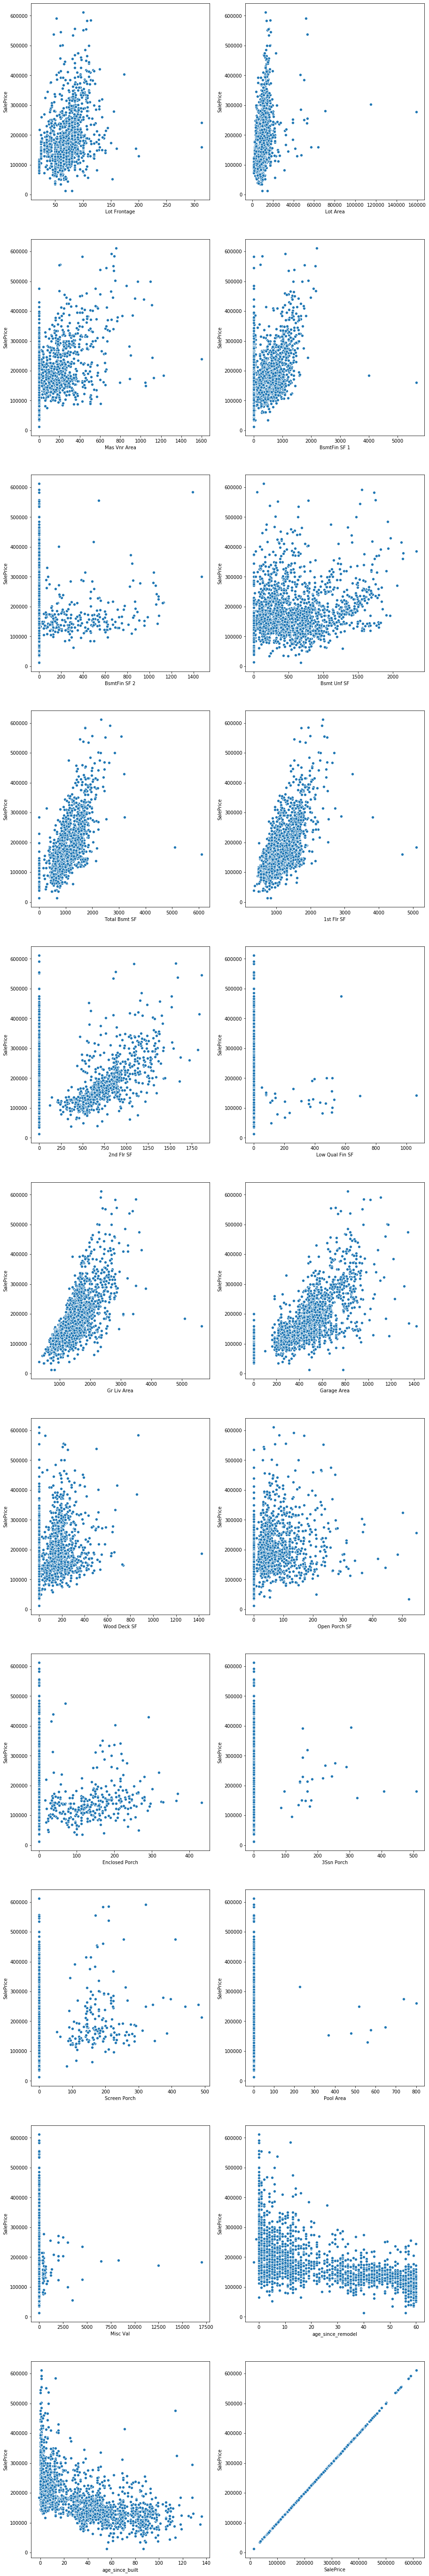

In [277]:
subplot_scatterplot(df,cont_columns)

From the scatter plots, we can observe several features that have some measure of correlation with prices, namely square footing in terms of Gross living area, house age and external lot areas. We can consider using them during the feature engineering process.

There are a number of features with value '0' but we will use Imputation after train_test_split just before model benchmarking

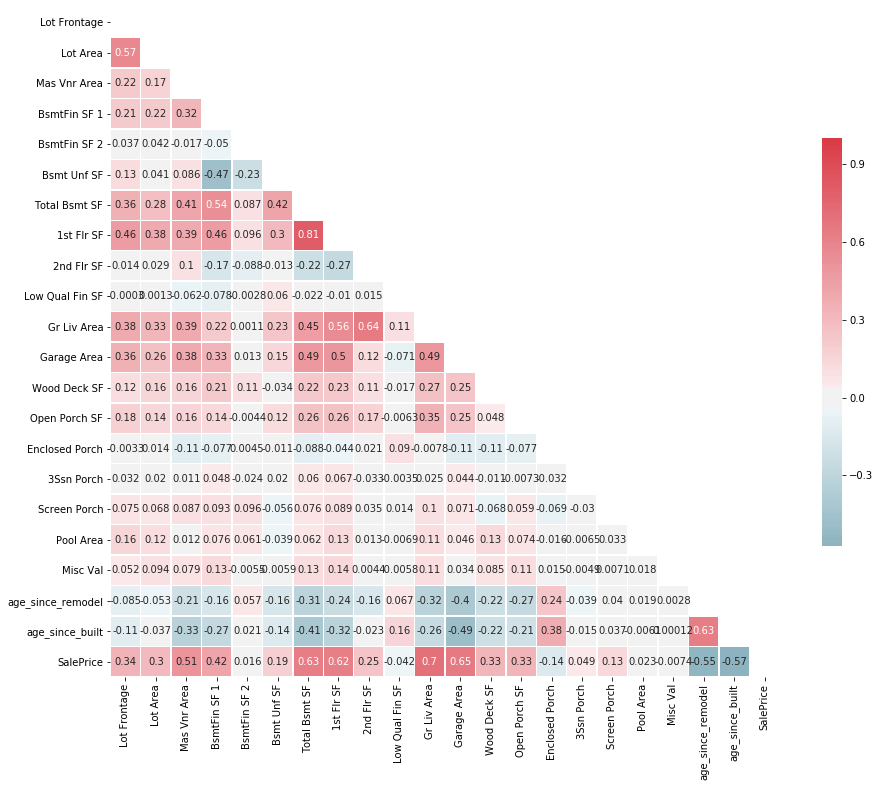

In [258]:
# Compute the correlation matrix
corr = df[cont_columns].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

From the correlation plot, we can see that Basement and first floor square footing as well as Gr Living area and garage area have an impact on the sale price. Age is also an important feature. Certain features can be dropped

/Users/syamil/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/syamil/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


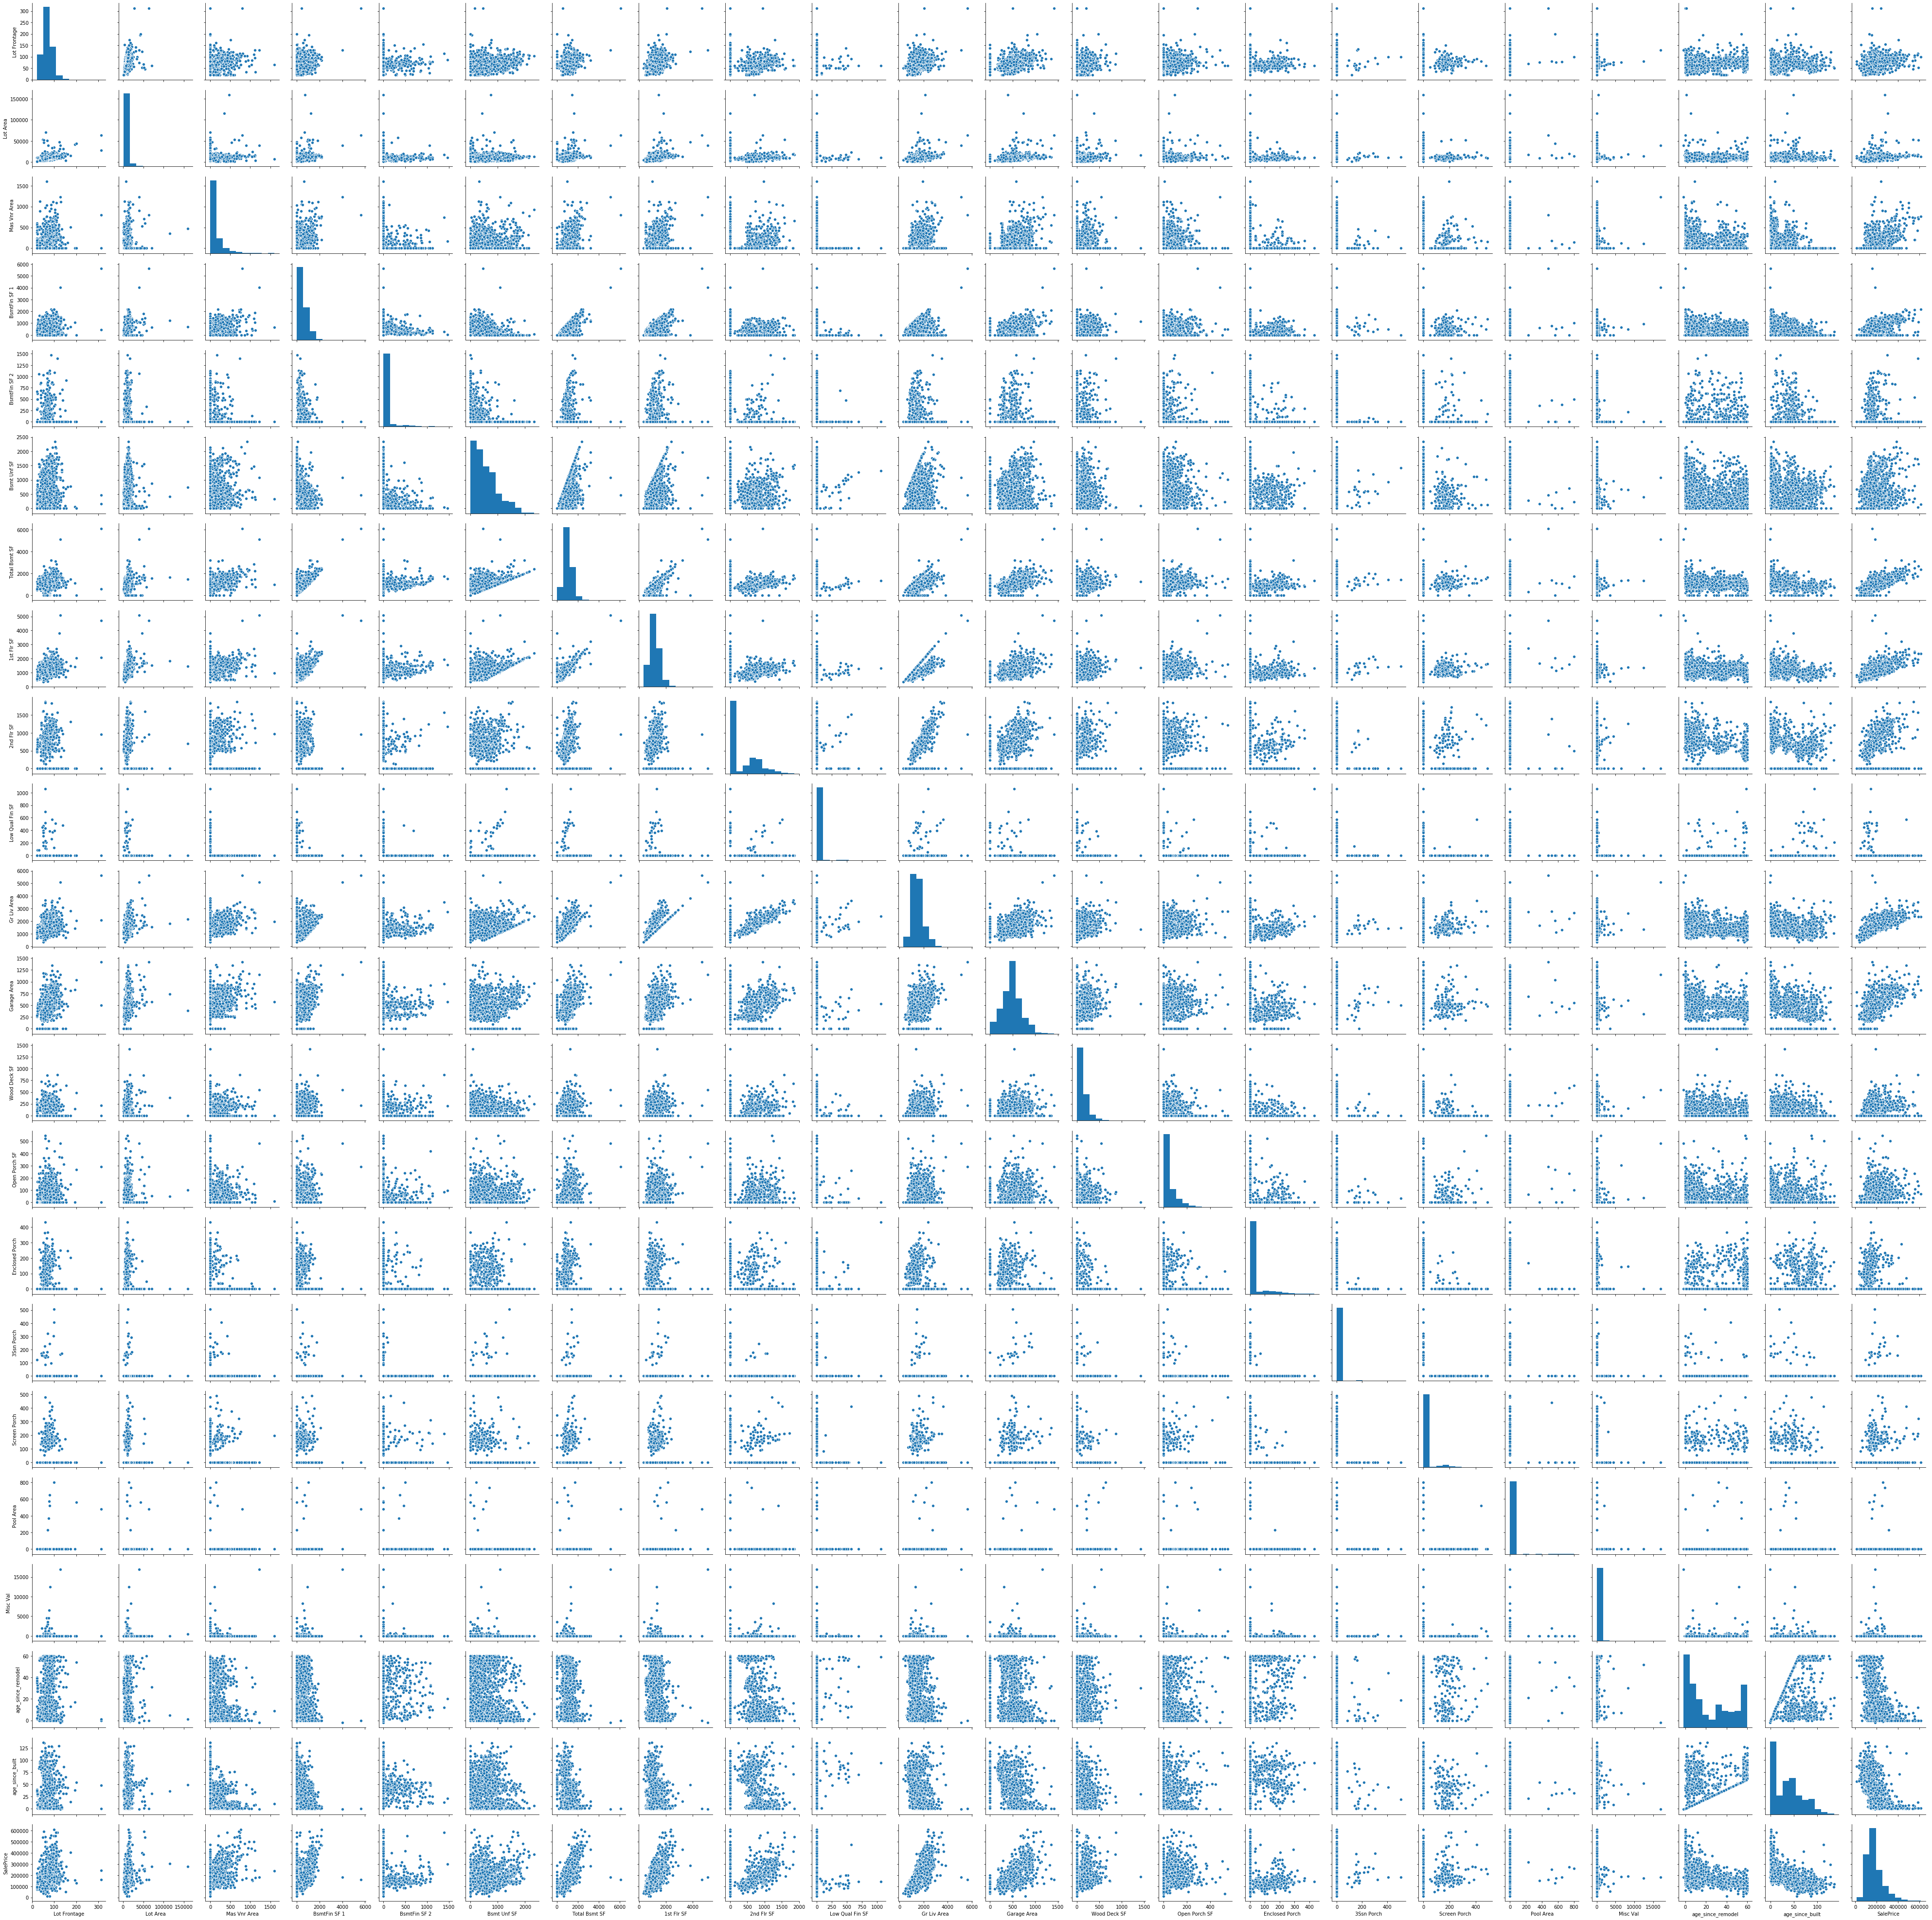

In [259]:
sns.pairplot(df[cont_columns])

In [260]:
df[cont_columns].isna().sum()

Lot Frontage         330
Lot Area               0
Mas Vnr Area          22
BsmtFin SF 1           1
BsmtFin SF 2           1
Bsmt Unf SF            1
Total Bsmt SF          1
1st Flr SF             0
2nd Flr SF             0
Low Qual Fin SF        0
Gr Liv Area            0
Garage Area            1
Wood Deck SF           0
Open Porch SF          0
Enclosed Porch         0
3Ssn Porch             0
Screen Porch           0
Pool Area              0
Misc Val               0
age_since_remodel      0
age_since_built        0
SalePrice              0
dtype: int64

# Store Results

In [261]:
nominal_features.append('Yr Sold')

In [1]:
combined_features = nominal_features + cont_columns

NameError: name 'nominal_features' is not defined

In [299]:
cont_columns

['Lot Frontage',
 'Lot Area',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'Garage Area',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Pool Area',
 'Misc Val',
 'age_since_remodel',
 'age_since_built',
 'SalePrice']

In [304]:
df[combined_features].to_csv('./datasets/modified_train.csv')